In [ ]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python"]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import cv2

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python


# Задание 1 Склейка панорамы

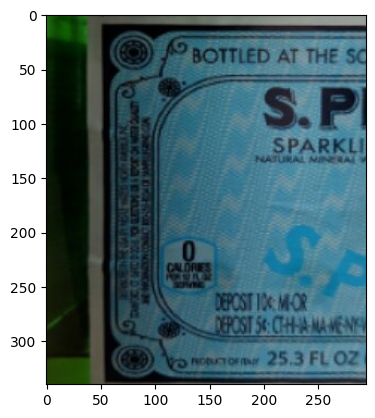

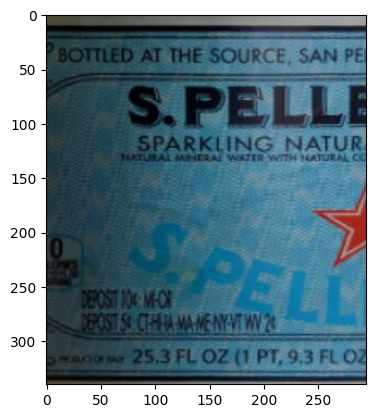

In [ ]:
img1 = cv2.imread('1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

img2 = cv2.imread('2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

In [ ]:
def resize_image(image, max_size=(340, 340)):
    h, w = image.shape[:2]
    scale = min(max_size[0] / h, max_size[1] / w)

    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h))

    if new_h > max_size[0] or new_w > max_size[1]:
        resized_image = resized_image[:max_size[0], :max_size[1]]

    return resized_image

def stitch_images(images):
    if len(images) < 2:
        return None

    images_resized = [resize_image(img) for img in images]

    sift = cv2.SIFT_create()

    prev_image = images_resized[0]
    for i in range(1, len(images_resized)):
        current_image = images_resized[i]

        prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
        current_gray = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)

        prev_keypoints, prev_descriptors = sift.detectAndCompute(prev_gray, None)
        current_keypoints, current_descriptors = sift.detectAndCompute(current_gray, None)

        prev_image_with_keypoints = cv2.drawKeypoints(prev_gray, prev_keypoints, None, color=(255, 0, 0))
        current_image_with_keypoints = cv2.drawKeypoints(current_gray, current_keypoints, None, color=(255, 0, 0))

        bf = cv2.BFMatcher()
        matches = bf.knnMatch(prev_descriptors, current_descriptors, k=2)


        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        if len(good_matches) > 4:
            src_pts = np.float32([prev_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([current_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            h, w = current_gray.shape
            warped_image = cv2.warpPerspective(prev_image, H, (w * 2, h))

            warped_image[0:h, 0:w] = current_image
            prev_image = warped_image

            plt.figure(figsize=(30, 20))
            plt.subplot(2, 2, 1), plt.imshow(current_image_with_keypoints, cmap='gray'), plt.title('Current Image Keypoints')
            plt.subplot(2, 2, 2), plt.imshow(prev_image_with_keypoints, cmap='gray'), plt.title('Previous Image Keypoints')


            plt.subplot(2, 2, 3)
            img_matches = cv2.drawMatches(prev_gray, prev_keypoints, current_gray, current_keypoints, good_matches, None)
            plt.imshow(img_matches, cmap='gray'), plt.title('Matches')

            plt.show()

        else:
            print("Не достаточно сопоставлений - %d/%d" % (len(good_matches), 4))
            return None

    return prev_image

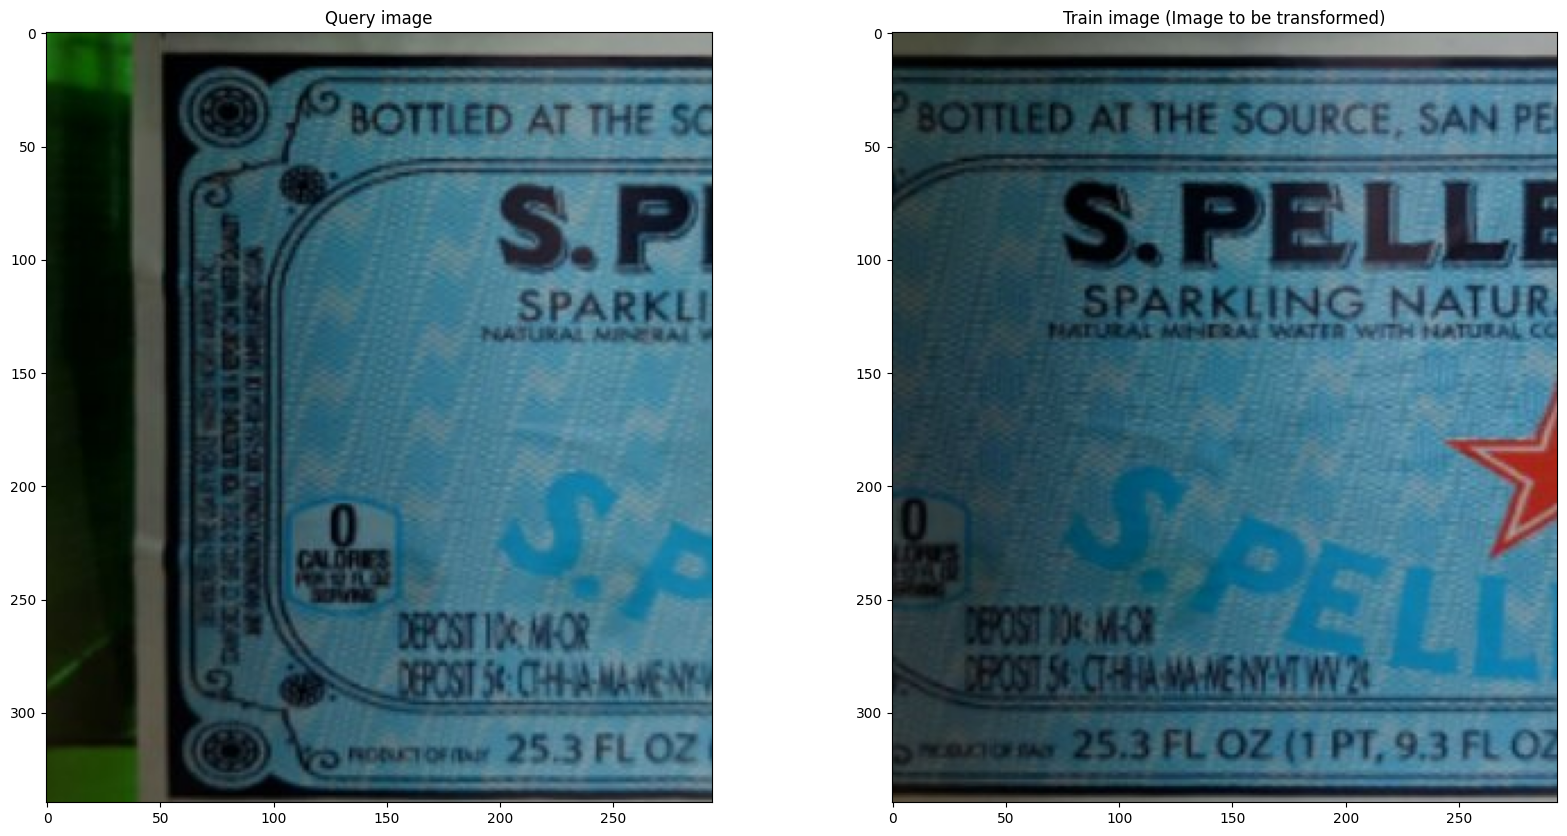

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(img1), plt.title('Query image')
plt.subplot(122), plt.imshow(img2), plt.title('Train image (Image to be transformed)')
plt.show()

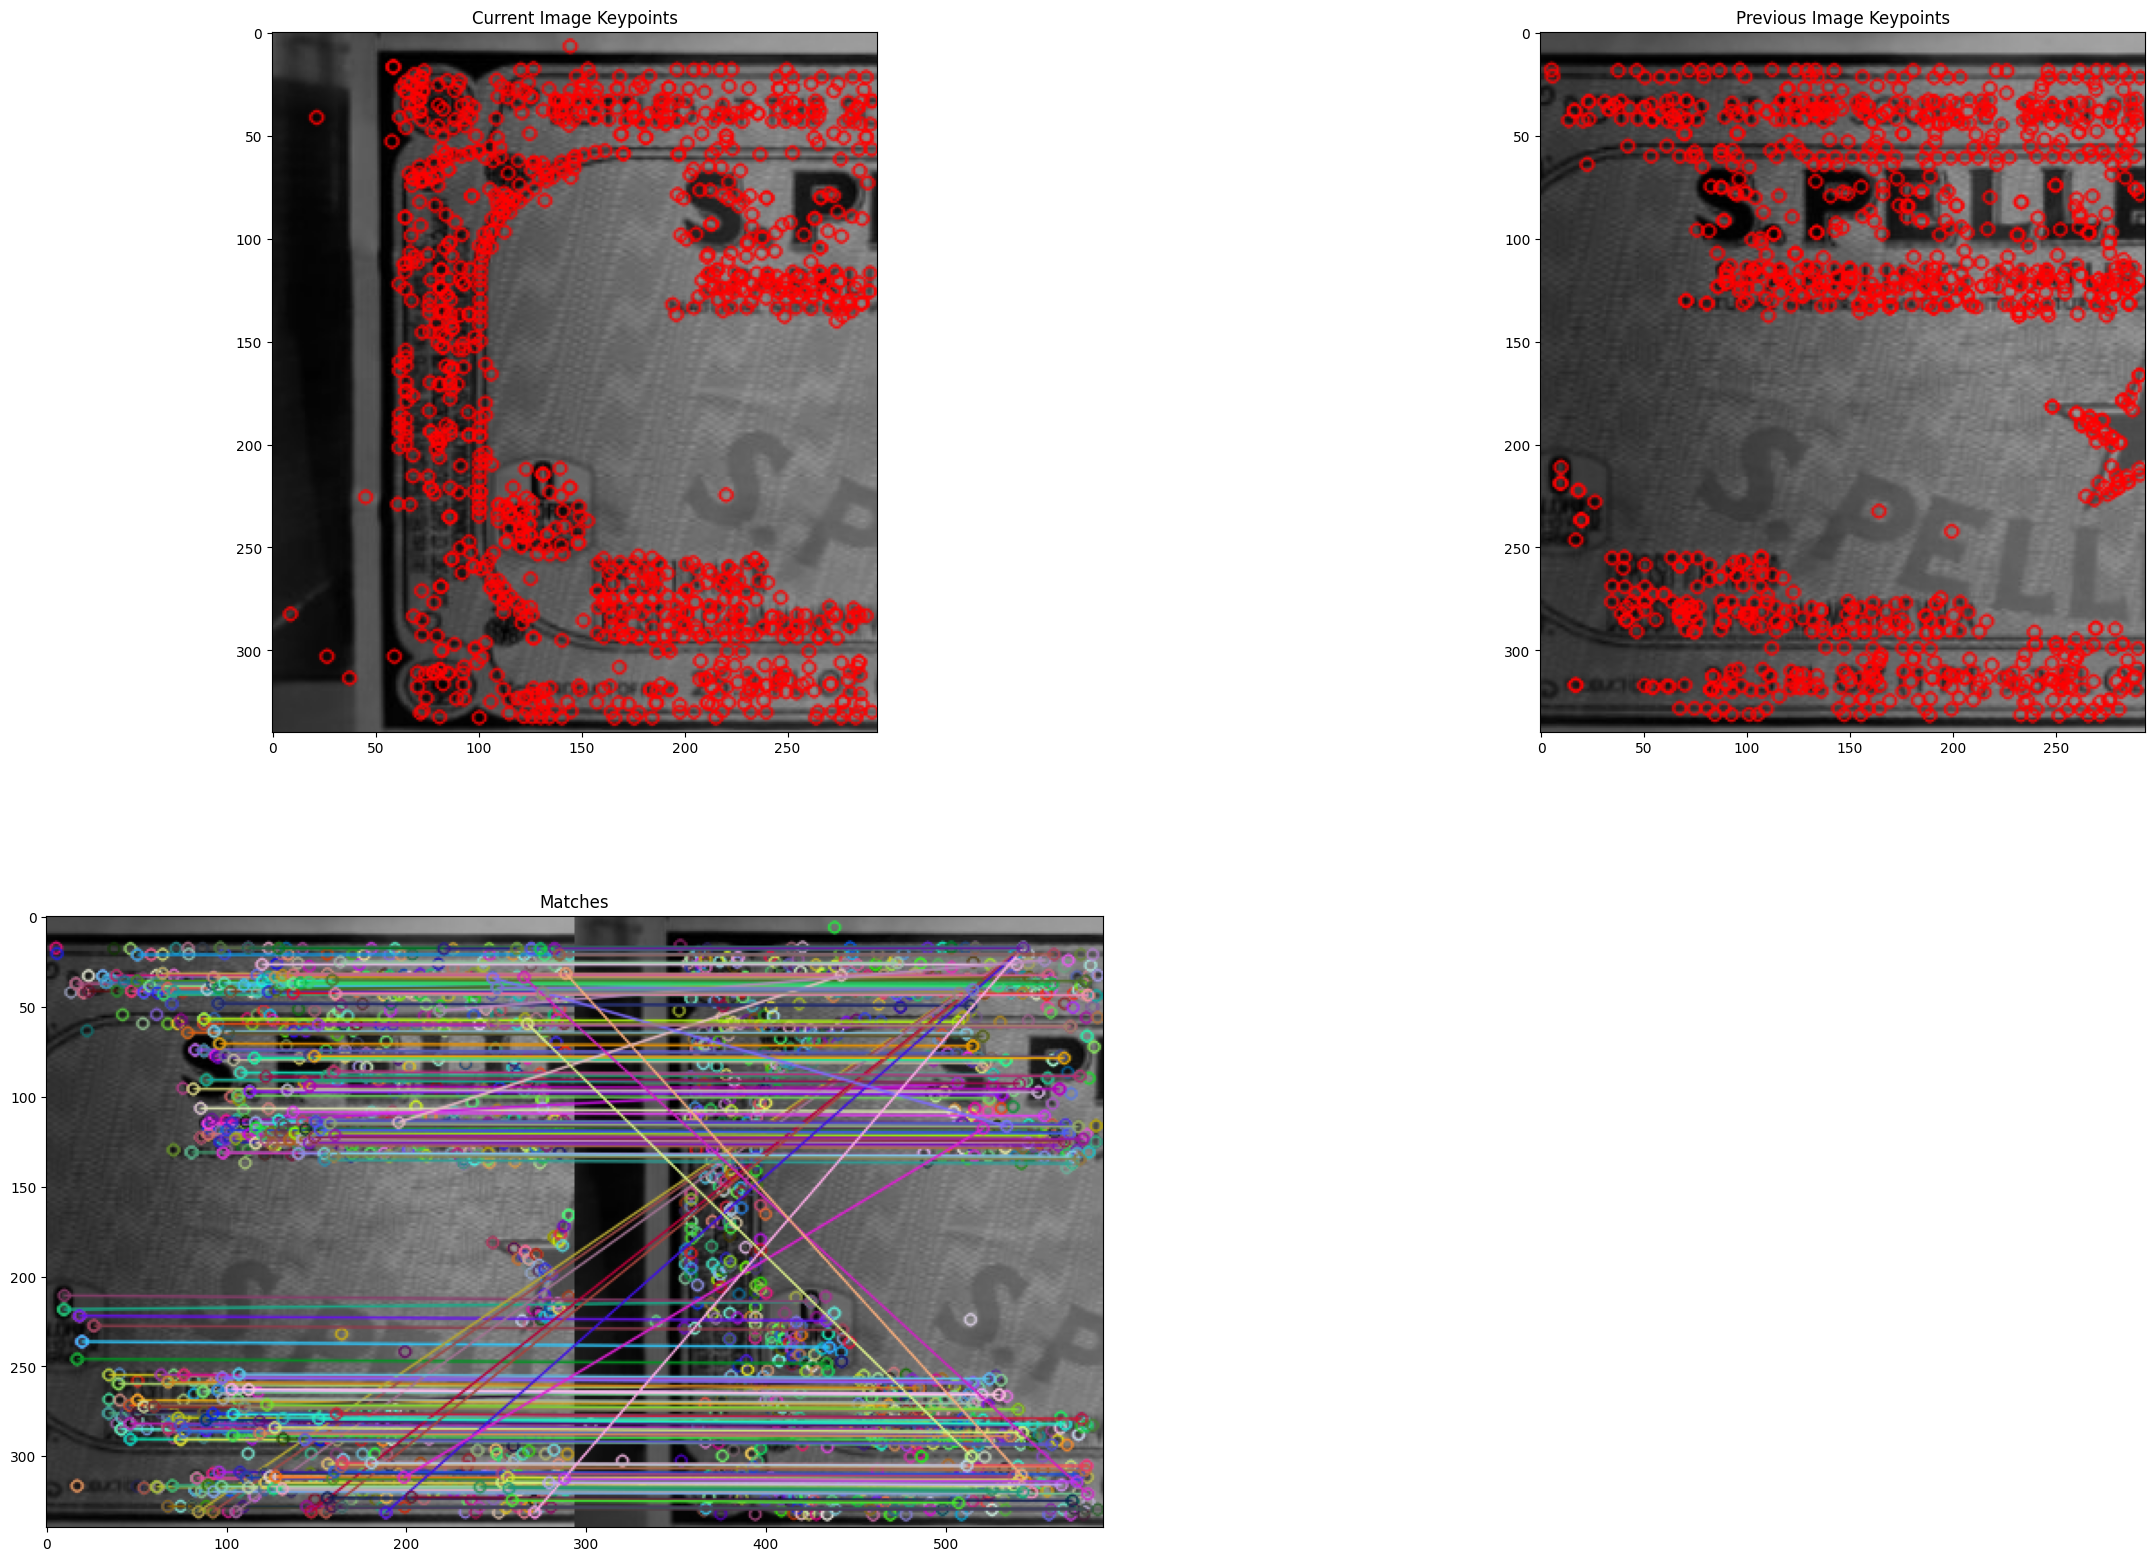

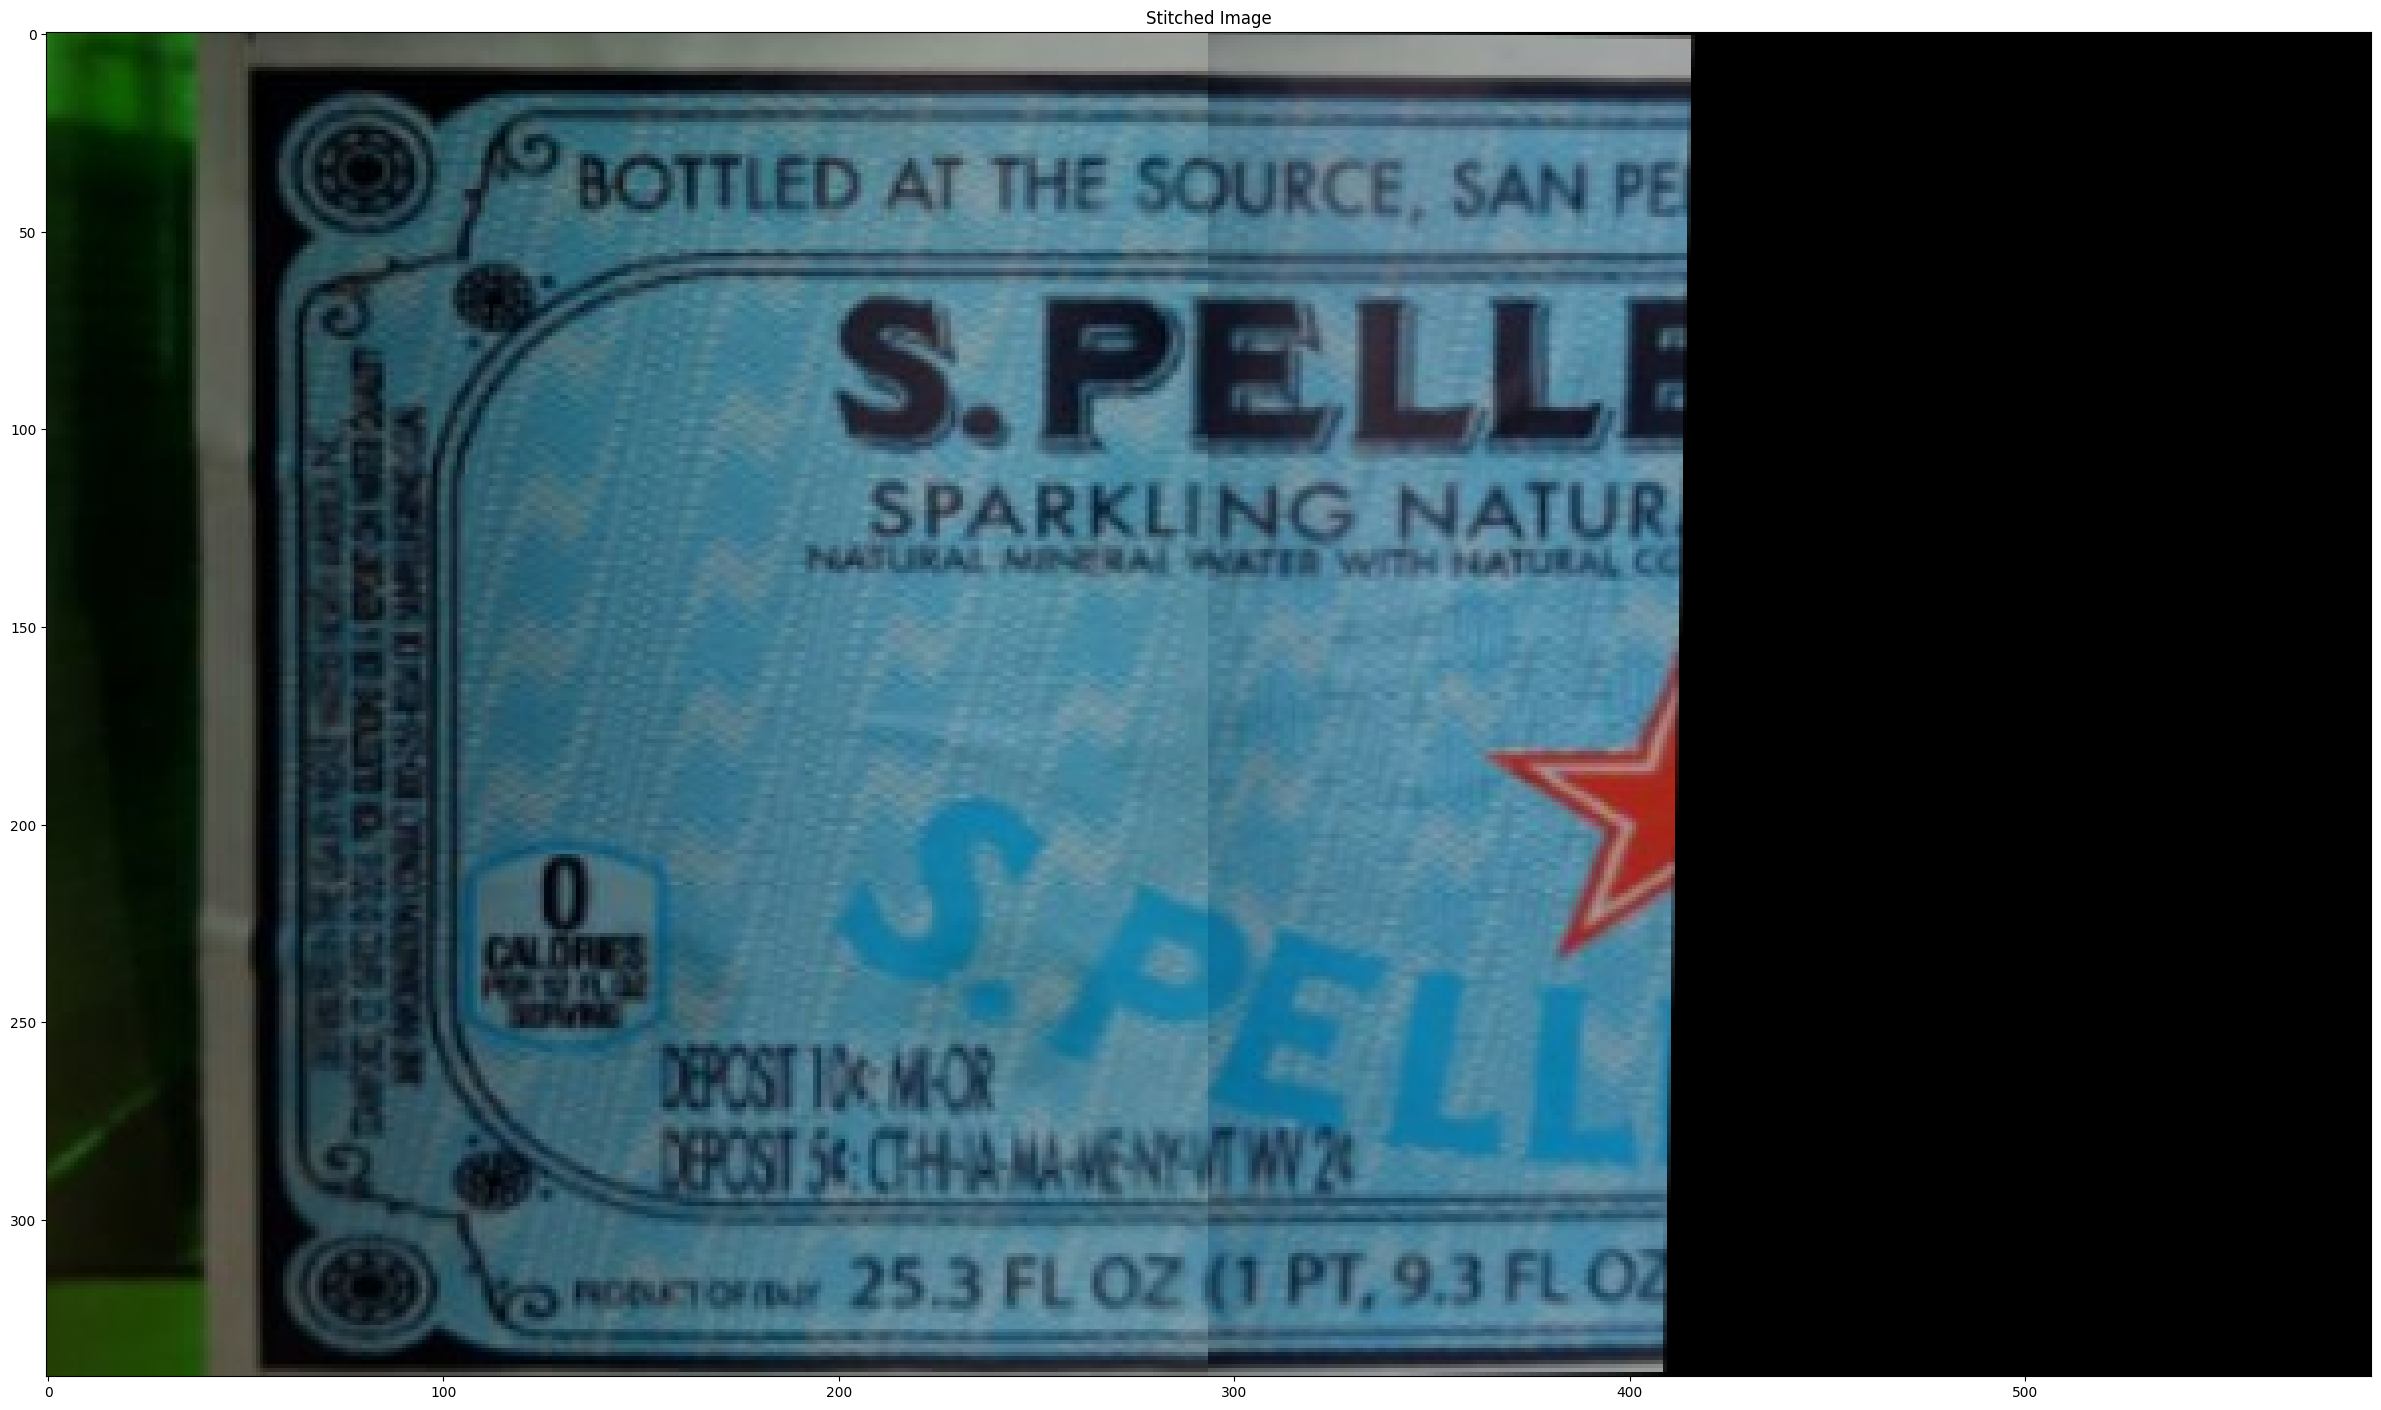

In [ ]:
image1 = cv2.imread('1.jpg')
image2 = cv2.imread('2.jpg')

result = stitch_images([image2, image1])

if result is not None:
    plt.figure(figsize=(30, 20))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Stitched Image')
    plt.show()
else:
    print("Недостаточно сопоставлений для склейки.")

# Задание 2 Оптический поток Лукаса — Канаде

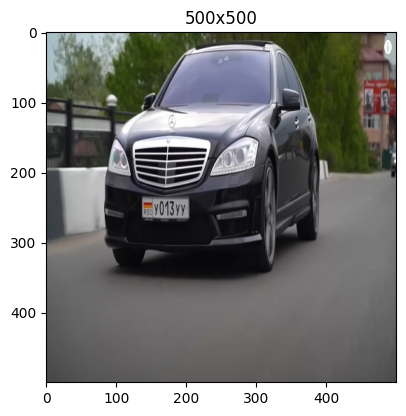

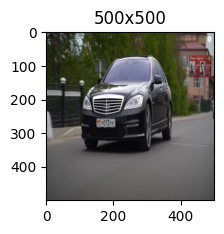

(<matplotlib.image.AxesImage at 0x7fbb8527fe20>,
 Text(0.5, 1.0, '500x500'),
 None)

In [ ]:
image1 = cv2.imread('s1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

image2 = cv2.imread('s2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image1 = cv2.resize(image1, (500, 500))
image2 = cv2.resize(image2, (500, 500))

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(image1), plt.title(f'{image2.shape[0]}x{image2.shape[1]}'), plt.show()

plt.subplot(222)
plt.imshow(image2), plt.title(f'{image2.shape[0]}x{image2.shape[1]}'), plt.show()

In [ ]:
def optic_flow(img1, img2, window_size):

    Ix = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=5)
    It = img2 - img1

    displacement_map = np.zeros_like(img1)

    half_window = window_size // 2

    for y in range(half_window, img1.shape[0] - half_window):
        for x in range(half_window, img1.shape[1] - half_window):

            Ix_window = Ix[y - half_window: y + half_window + 1, x - half_window: x + half_window + 1].flatten()
            Iy_window = Iy[y - half_window: y + half_window + 1, x - half_window: x + half_window + 1].flatten()
            It_window = It[y - half_window: y + half_window + 1, x - half_window: x + half_window + 1].flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window.reshape((-1, 1))

            if np.linalg.matrix_rank(np.dot(A.T, A)) >= 2:
                v = np.dot(np.linalg.pinv(A), b)
                displacement_map[y, x] = v[0]

    return displacement_map

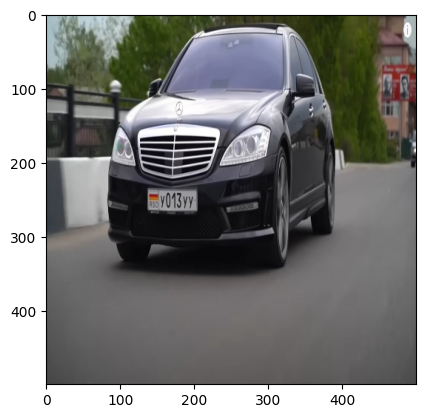

<ipython-input-30-54426bc9ee5a>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  displacement_map[y, x] = v[0]


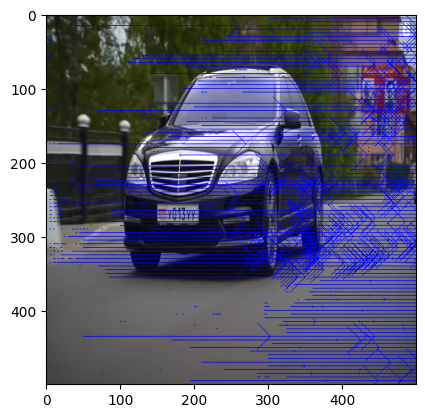

In [ ]:
frames = [image1, image2]

prev_frame = None

for frame in frames:
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if prev_frame is not None:
        displacement_map = optic_flow(prev_frame, gray_frame, 5)
        displacement_map = cv2.normalize(displacement_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        for y in range(0, displacement_map.shape[0], 5):
            for x in range(0, displacement_map.shape[1], 5):
                displacement = displacement_map[y, x]
                if displacement != 0:
                    cv2.arrowedLine(frame, (x, y), (x + displacement, y), (0, 0, 255), 1)

    prev_frame = gray_frame

    plt.imshow(frame)
    plt.show()